# Gestures Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/sign-language-gesture-images-dataset.zip"

Importing `Libraries`

In [3]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
batch_size = 18
img_height = 70
img_width = 70

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/Gesture Image Pre-Processed Data",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  subset="training",
  validation_split=0.25)

Found 55500 files belonging to 37 classes.
Using 41625 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/Gesture Image Pre-Processed Data",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  subset="validation",
  validation_split=0.25)

Found 55500 files belonging to 37 classes.
Using 13875 files for validation.


In [12]:
class_names = train_ds.class_names
num_classes =len(class_names)
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']


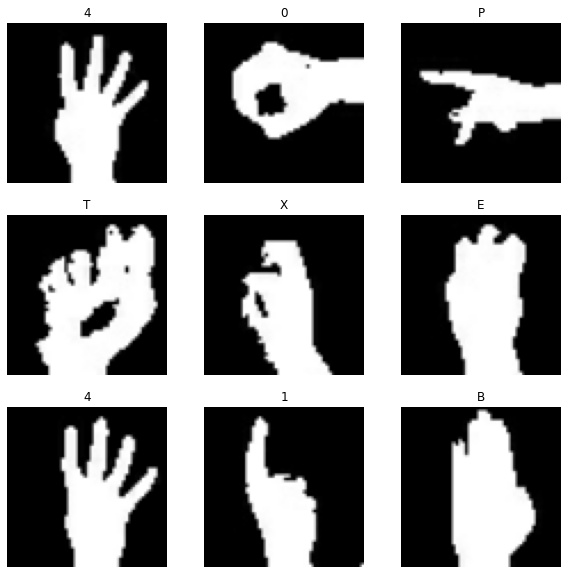

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [16]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
checkpoint = ModelCheckpoint("gesture_classification.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [19]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
2313/2313 [==============================] - 59s 10ms/step - loss: 0.4028 - accuracy: 0.8735 - val_loss: 0.0620 - val_accuracy: 0.9751

Epoch 00001: val_loss improved from inf to 0.06196, saving model to gesture_classification.h5
Epoch 2/100
2313/2313 [==============================] - 13s 6ms/step - loss: 0.0673 - accuracy: 0.9785 - val_loss: 0.0143 - val_accuracy: 0.9953

Epoch 00002: val_loss improved from 0.06196 to 0.01426, saving model to gesture_classification.h5
Epoch 3/100
2313/2313 [==============================] - 13s 6ms/step - loss: 0.0443 - accuracy: 0.9859 - val_loss: 0.0107 - val_accuracy: 0.9972

Epoch 00003: val_loss improved from 0.01426 to 0.01072, saving model to gesture_classification.h5
Epoch 4/100
2313/2313 [==============================] - 13s 6ms/step - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0244 - val_accuracy: 0.9914

Epoch 00004: val_loss did not improve from 0.01072
Epoch 5/100
2313/2313 [==============================] - 13s 6ms/step 

In [20]:
model_json = model.to_json()
with open("model_keras.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_keras.h5")

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

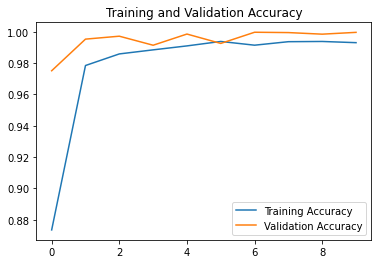

In [22]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

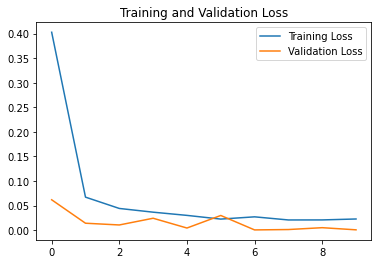

In [23]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to 0 with a 100.00 percent confidence.


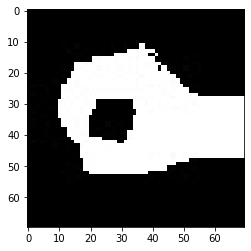

In [25]:
img = keras.preprocessing.image.load_img(
    "/content/Gesture Image Pre-Processed Data/0/1002.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 1 with a 100.00 percent confidence.


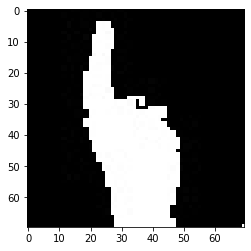

In [26]:
img = keras.preprocessing.image.load_img(
    "/content/Gesture Image Pre-Processed Data/1/1002.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 5 with a 100.00 percent confidence.


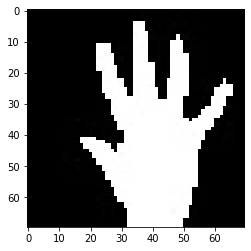

In [27]:
img = keras.preprocessing.image.load_img(
    "/content/Gesture Image Pre-Processed Data/5/1002.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to G with a 100.00 percent confidence.


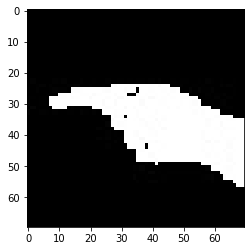

In [28]:
img = keras.preprocessing.image.load_img(
    "/content/Gesture Image Pre-Processed Data/G/1002.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to M with a 100.00 percent confidence.


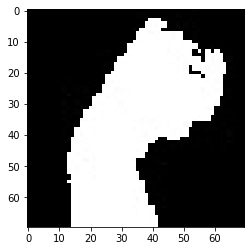

In [29]:
img = keras.preprocessing.image.load_img(
    "/content/Gesture Image Pre-Processed Data/M/1002.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)